In [1]:
from utils.IBRS import TRC, RSU, OBU
import time
from decimal import Decimal
import csv

from utils.drawtools import pltbar

In [2]:
with open('./data/VID.csv') as f:
    csv_reader = csv.reader(f)
    head = next(csv_reader)

    VID_POOL = [x for x in csv_reader]

In [3]:
N = 1 # 实验次数，最后结果取平均

---

## [Round1 - OBU Generation] SS512 vs MNT159


In [4]:
def test_obugen(N, L, t_trc):
    recorder = []
    trc = TRC(t_trc, L, 'exp #1')
    start = time.process_time()
    for i in range(N):
        obu = OBU(trc, VID_POOL[i])
    end = time.process_time()
    cost = Decimal((Decimal(end) - Decimal(start)) * 1000 / N).quantize(Decimal("0.00"))
    return cost

横坐标： 二叉树的深度，`range(10, 21)`

纵坐标： 时间，单位：毫秒 （精确到小数点后两位）

比较对象： SS512, MNT159

---

In [5]:
types = ['MNT159', 'SS512']
time_cost = [[], []]
for i, t in enumerate(types):
    for j in range(10, 13):
        result = test_obugen(N, j, t)
        time_cost[i].append(float(result))
time_cost

[[2.5, 3.46, 2.65], [17.11, 18.12, 17.36]]

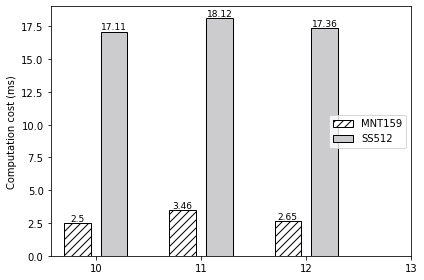

In [6]:
# data = [(x,y) for x, y in zip(*time_cost)]

pltbar(3, 0.35, time_cost, ['MNT159', 'SS512'], range(10, 14), 'Computation cost (ms)')